<a href="https://colab.research.google.com/github/dedeepya-M/covid_prediction/blob/main/lung_segmentation.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
! pip install kaggle

In [2]:
! mkdir ~/.kaggle

mkdir: cannot create directory ‘/root/.kaggle’: File exists


In [3]:
! cp kaggle.json ~/.kaggle/

In [4]:
! chmod 600 ~/.kaggle/kaggle.json

In [5]:
! kaggle datasets download -d kmader/finding-lungs-in-ct-data

 99% 1.02G/1.03G [00:15<00:00, 67.8MB/s]
100% 1.03G/1.03G [00:15<00:00, 69.8MB/s]


In [6]:
import pandas as pd
import numpy as np
import cv2
%matplotlib inline
import matplotlib.pyplot as plt
import zipfile
import os

In [7]:
sourcepath = "/content/finding-lungs-in-ct-data.zip"
target = "/content/drive/MyDrive/lungct"

In [9]:
zf = zipfile.ZipFile(sourcepath)
zf.extractall(target)

In [10]:
images_path = "/content/drive/MyDrive/lungct/2d_images/"
label_path = "/content/drive/MyDrive/lungct/2d_masks/"

In [11]:
images = os.listdir(images_path)
masks = os.listdir(label_path)
print(len(images))
print(len(masks))

267
267


In [12]:
import glob
from PIL import Image
from tqdm import tqdm

In [13]:
IMG_WIDTH = 256
IMG_HEIGHT = 256

In [14]:
mask_list = []
for filename in glob.glob(label_path+"*.tif"): 
    im=Image.open(filename)
    im = im.resize((512,512))
    mask_list.append(np.array(im))

In [15]:
image_list = []
for filename in glob.glob(images_path+"*.tif"): 
    im=Image.open(filename)
    im = im.resize((512,512))
    image_list.append(np.array(im))

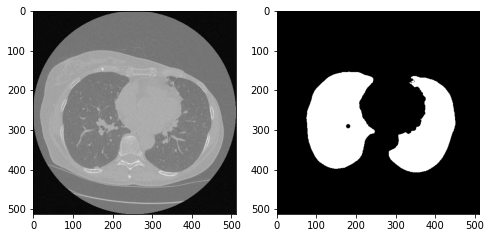

In [16]:
fig, ax = plt.subplots(1,2, figsize = (8,4))
ax[0].imshow(image_list[3], cmap='gray')
ax[1].imshow(mask_list[3], cmap='gray')
plt.show()

In [17]:
def plotMask(X,y):
    sample = []
    
    for i in range(6):
        left = X[i]
        right = y[i]
        combined = np.hstack((left,right))
        sample.append(combined)
        
        
    for i in range(0,6,3):

        plt.figure(figsize=(25,10))
        
        plt.subplot(2,3,1+i)
        plt.imshow(sample[i],cmap = 'gray')
        
        plt.subplot(2,3,2+i)
        plt.imshow(sample[i+1],cmap='gray')
        
        
        plt.subplot(2,3,3+i)
        plt.imshow(sample[i+2],cmap='gray')
        
        plt.show()

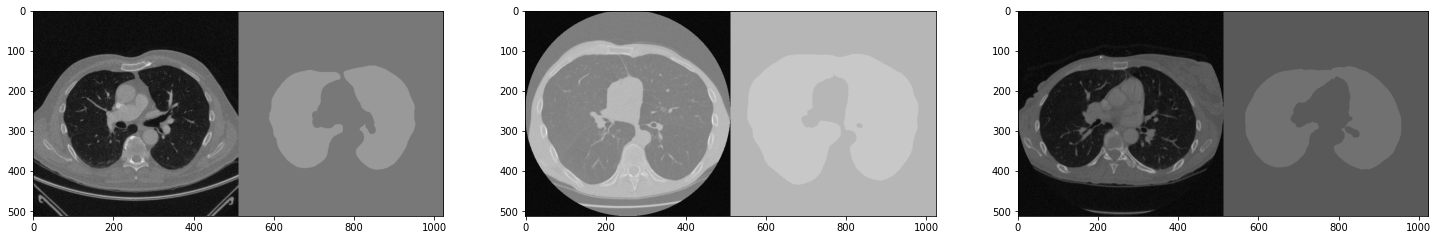

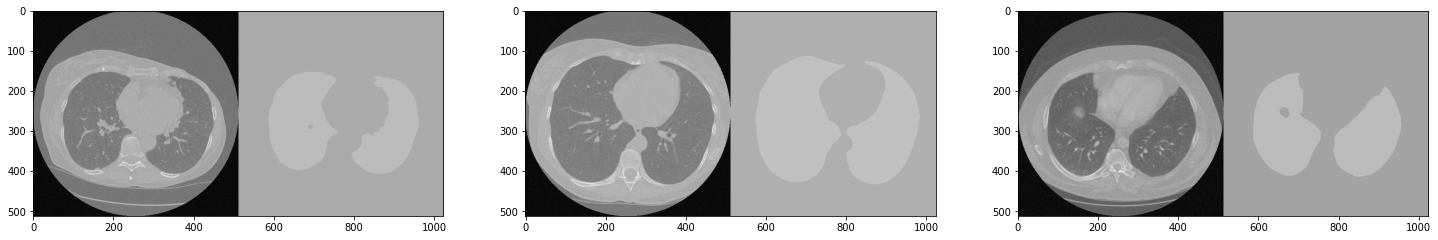

In [18]:
plotMask(image_list,mask_list)

In [19]:
image_list = np.array(image_list,dtype='float64')/255.0
mask_list = np.array(mask_list,dtype='float64')/255.0

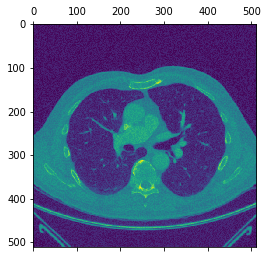

In [20]:
plt.matshow(image_list[0])

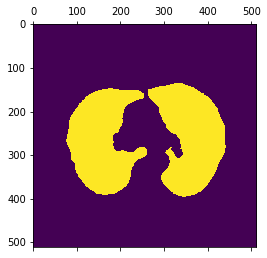

In [21]:
plt.matshow(mask_list[0])

In [22]:
from keras.models import *
from keras.layers import *
from tensorflow.keras.optimizers import Adam
from keras import backend as keras
from keras.preprocessing.image import ImageDataGenerator
from keras.callbacks import ModelCheckpoint, LearningRateScheduler

In [23]:
def dice_coef(y_true, y_pred):
    y_true_f = keras.flatten(y_true)
    y_pred_f = keras.flatten(y_pred)
    intersection = keras.sum(y_true_f * y_pred_f)
    return (2. * intersection + 1) / (keras.sum(y_true_f) + keras.sum(y_pred_f) + 1)

In [24]:
def dice_coef_loss(y_true, y_pred):
    return -dice_coef(y_true, y_pred)

In [25]:
def unet(input_size=(512,512,1)):
    inputs = Input(input_size)
    
    conv1 = Conv2D(32, (3, 3), activation='relu', padding='same')(inputs)
    conv1 = Conv2D(32, (3, 3), activation='relu', padding='same')(conv1)
    pool1 = MaxPooling2D(pool_size=(2, 2))(conv1)

    conv2 = Conv2D(64, (3, 3), activation='relu', padding='same')(pool1)
    conv2 = Conv2D(64, (3, 3), activation='relu', padding='same')(conv2)
    pool2 = MaxPooling2D(pool_size=(2, 2))(conv2)

    conv3 = Conv2D(128, (3, 3), activation='relu', padding='same')(pool2)
    conv3 = Conv2D(128, (3, 3), activation='relu', padding='same')(conv3)
    pool3 = MaxPooling2D(pool_size=(2, 2))(conv3)

    conv4 = Conv2D(256, (3, 3), activation='relu', padding='same')(pool3)
    conv4 = Conv2D(256, (3, 3), activation='relu', padding='same')(conv4)
    pool4 = MaxPooling2D(pool_size=(2, 2))(conv4)

    conv5 = Conv2D(512, (3, 3), activation='relu', padding='same')(pool4)
    conv5 = Conv2D(512, (3, 3), activation='relu', padding='same')(conv5)

    up6 = concatenate([Conv2DTranspose(256, (2, 2), strides=(2, 2), padding='same')(conv5), conv4], axis=3)
    conv6 = Conv2D(256, (3, 3), activation='relu', padding='same')(up6)
    conv6 = Conv2D(256, (3, 3), activation='relu', padding='same')(conv6)

    up7 = concatenate([Conv2DTranspose(128, (2, 2), strides=(2, 2), padding='same')(conv6), conv3], axis=3)
    conv7 = Conv2D(128, (3, 3), activation='relu', padding='same')(up7)
    conv7 = Conv2D(128, (3, 3), activation='relu', padding='same')(conv7)

    up8 = concatenate([Conv2DTranspose(64, (2, 2), strides=(2, 2), padding='same')(conv7), conv2], axis=3)
    conv8 = Conv2D(64, (3, 3), activation='relu', padding='same')(up8)
    conv8 = Conv2D(64, (3, 3), activation='relu', padding='same')(conv8)

    up9 = concatenate([Conv2DTranspose(32, (2, 2), strides=(2, 2), padding='same')(conv8), conv1], axis=3)
    conv9 = Conv2D(32, (3, 3), activation='relu', padding='same')(up9)
    conv9 = Conv2D(32, (3, 3), activation='relu', padding='same')(conv9)

    conv10 = Conv2D(1, (1, 1), activation='sigmoid')(conv9)

    return Model(inputs=[inputs], outputs=[conv10])

In [26]:
from sklearn.model_selection import train_test_split

In [27]:
x_train, x_test, y_train, y_test = train_test_split(image_list,mask_list, test_size = 0.2)

In [28]:
print(x_train.shape)
print(x_test.shape)

(213, 512, 512)
(54, 512, 512)


In [47]:
from tensorflow.keras.optimizers import Adam,RMSprop
model = unet(input_size=(512,512,1))
model.compile(optimizer='adam', loss=dice_coef_loss,
                  metrics=[dice_coef, 'accuracy'])
#model.summary()

In [ ]:
loss_history = model.fit(x = x_train,
                       y = y_train,
                         batch_size = 16,
                  epochs = 20,
                  steps_per_epoch = 20,
                  validation_data =(x_test,y_test) ,
                  verbose = 1
)

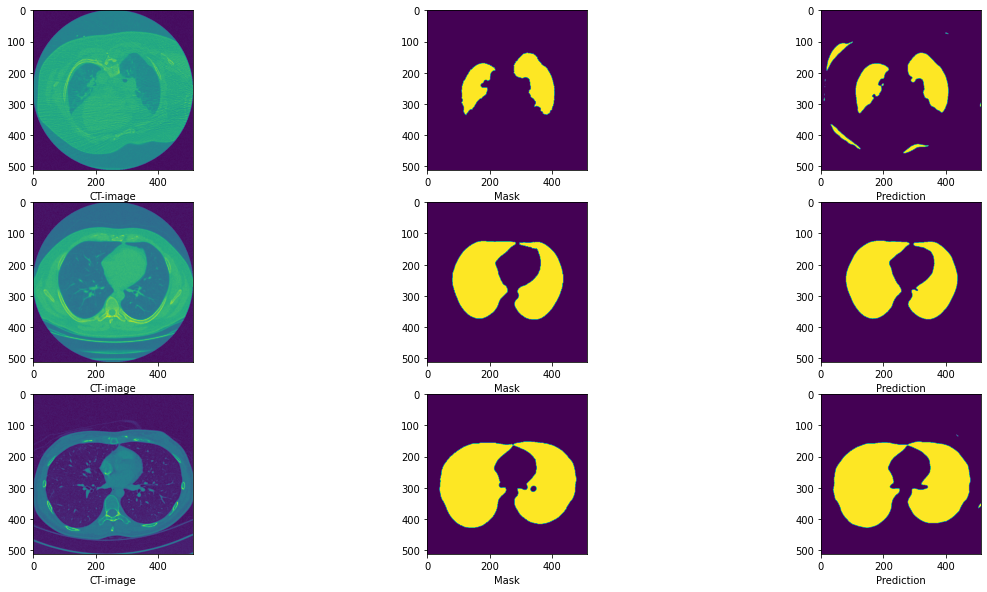

In [52]:
pred_candidates = np.random.randint(1,x_test.shape[0],10)
preds = model.predict(x_test)

plt.figure(figsize=(20,10))

for i in range(0,9,3):
    plt.subplot(3,3,i+1)
    
    plt.xlabel("CT-image")
    plt.imshow(np.squeeze(x_test[pred_candidates[i]]))
     
    
    plt.subplot(3,3,i+2)
    plt.xlabel("Mask")
    plt.imshow(np.squeeze(y_test[pred_candidates[i]]))
        
    plt.subplot(3,3,i+3)
    plt.xlabel("Prediction")
    plt.imshow(np.squeeze(preds[pred_candidates[i]]))

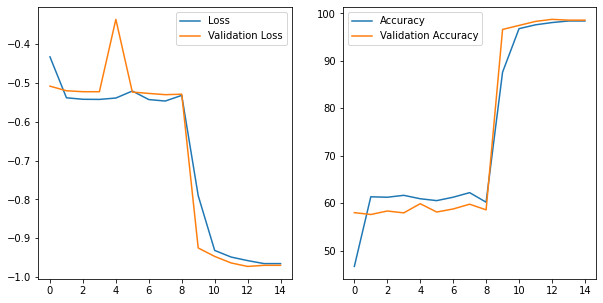

In [59]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize = (10, 5))
ax1.plot(loss_history.history['loss'], '-', label = 'Loss')
ax1.plot(loss_history.history['val_loss'], '-', label = 'Validation Loss')
ax1.legend()

ax2.plot(100*np.array(loss_history.history['accuracy']), '-', 
         label = 'Accuracy')
ax2.plot(100*np.array(loss_history.history['val_accuracy']), '-',
         label = 'Validation Accuracy')
ax2.legend()